Explanation of notebooks: 

- The $\textbf{Exoplanet Practice notebook}$ models the transits for the planetary system, and subtracts the model from the pld data to see if histogram of noise is gaussian. This notebook finds there is lots of non-gaussian noise, indiciating a bug. 
- The $\textbf{Outliers Removal - Histogram-bug notebook}$ tries using MAST lightkurve instead of pld but still replicates this bug.
- The $\textbf{TPF files notebook}$ explains why the pld data had weird features. If I stitch lightcurves from different quarters and then flatten them, they introduce those features. If I flatten each quarter and THEN stitch, the features are no longer there. 
- The $\textbf{Outliers Removal - Histogram-pld notebook}$ goes back to using pld but fixes the bug (found to be using the wrong time array in exoplanet model). This notebook also tries to explore the pld data's weird featurues  
- The $\textbf{Outliers Removal - Histogram-sap notebook}$ tries using sap but fixes the time array bug 
- The $\textbf{Outliers Removal - Histogram notebook}$ uses MAST lightkurve and fixes the bug (found to be using the wrong time array in exoplanet model). Histogram looks good but folded light curve found to have shoulders. 

The MAST lightkurve + time array bug fix was the combination that led to the least amount of outliers. However, the folded light curve had shoulders, so flattening needs to be removed. 


In [2]:
import exoplanet as xo 
import lightkurve as lk 
import astropy.units as units
import matplotlib.pyplot as plt 
import numpy as np 
import math
%matplotlib inline
from astropy.time import Time 
import sys 
sys.path.append("helpers")
import data 
import xo_archive
import fit
xo.utils.docs_setup()
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.family'] = 'DeJavu Serif'
import matplotlib.font_manager
from scipy.stats import norm 
import statistics
from importlib import reload

reload(fit)

<module 'fit' from '/Users/suissa/radius-valley/helpers/fit.py'>

In [3]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)


students-t distribution incompatible with Gaussian Processes 
correlated noise - multidimensional GP 

1) outliers could be due to flares, poor fit to the data, systematics 
2) systematic noise - pointing drift 
3) stellar correlations 

Ideally need a probability distribution to account for all of these 

1 and 3 are basically impossible to implement simultaneously 
1 use histogram or CDF 
2 look at correlation between x/y position vs the flux 

need to look if theres any correlation in x and y positions 

PLD - look at it in the lightkurve package, should have removed large dips 

ACF for 3 - auto correlation function 

# seeing if using the lk lightcurves instead works 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

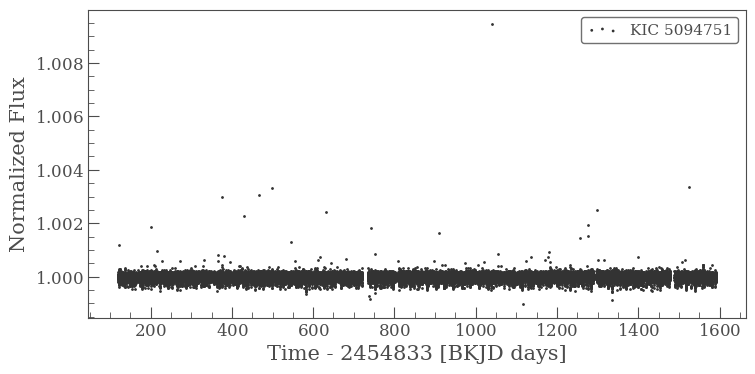

In [77]:
# trying to flatten first and then stitch

search_results = lk.search_lightcurve("Kepler-109", mission="Kepler", exptime=1800)
lcc = search_results.download_all()
lcc = lk.LightCurveCollection([i.flatten() for i in lcc])
lc = lcc.stitch().remove_nans()
lc.scatter()

(200.0, 600.0)

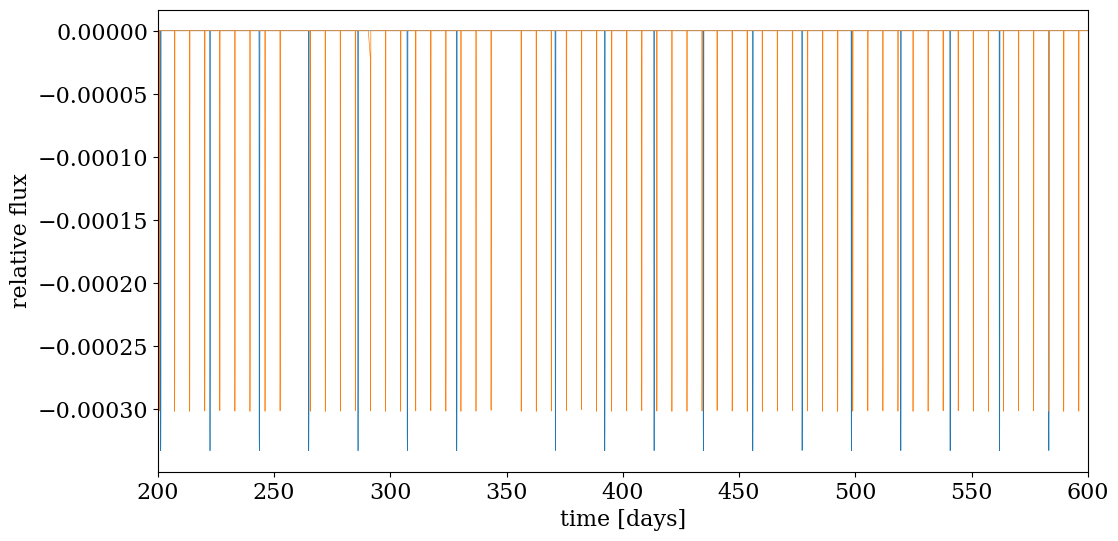

In [78]:
constant = 1

orbits = {}
for i in range(len(param_lists['pl_letter'])):
    orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], t0=(Time(param_lists["pl_tranmid"][i],
                                 format="jd").bkjd),b=param_lists['pl_imppar'][i], duration=param_lists['pl_trandur'][i]/24,
                                                                   r_star=param_lists['st_rad'][i],ror=param_lists['pl_ratror'][i])
t = lc.time.value
u = [0.2, 0.2]

light_curves = {}
for i in range(len(param_lists['pl_letter'])):
    light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],t=t)
    .eval())

plt.figure(figsize=(12,6))
plt.plot(t, light_curves['c'], color="C0", lw=0.5)
plt.plot(t, light_curves['b'], color="C1", lw=0.5)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(200,600)

In [79]:
dataset = np.array(lc.flux)

model = light_curves['c']+light_curves['b']

In [80]:
model = model.flatten()

In [81]:
difference = (dataset - model)

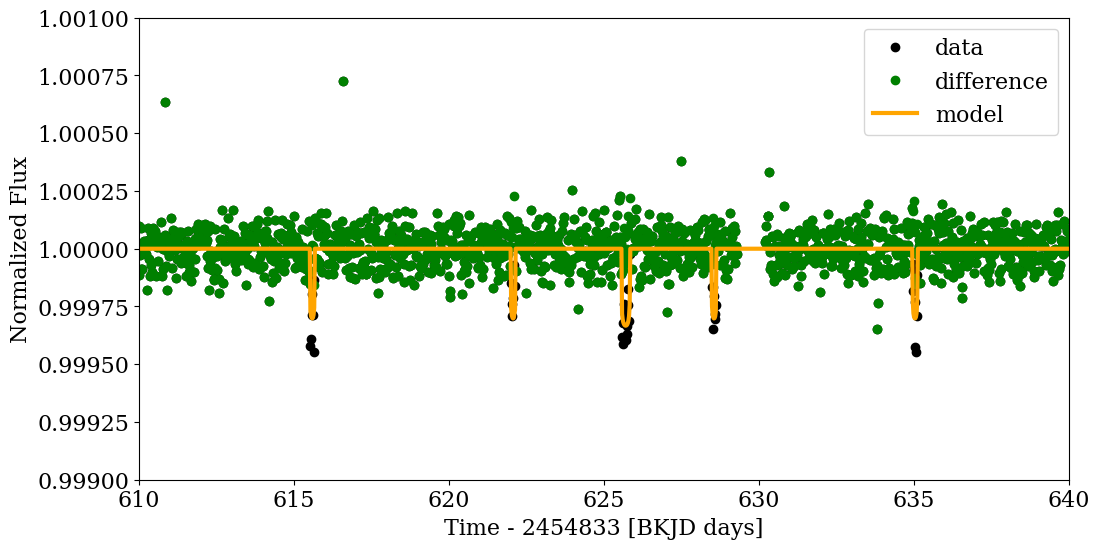

In [82]:
p = lc.scatter()
plt.close()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(lc.time.value,lc.flux.value,color='k',marker='o',ls='',label='data')
plt.plot(lc.time.value,difference,marker='o',ls='',color='green',label='difference')
plt.plot(t, model+1,color='orange',lw=3,label='model')
plt.xlabel(p.get_xlabel())
plt.ylabel(p.get_ylabel())
plt.xlim(610,640)
plt.ylim(0.999, 1.001)
plt.legend()

(0.9994, 1.0006)

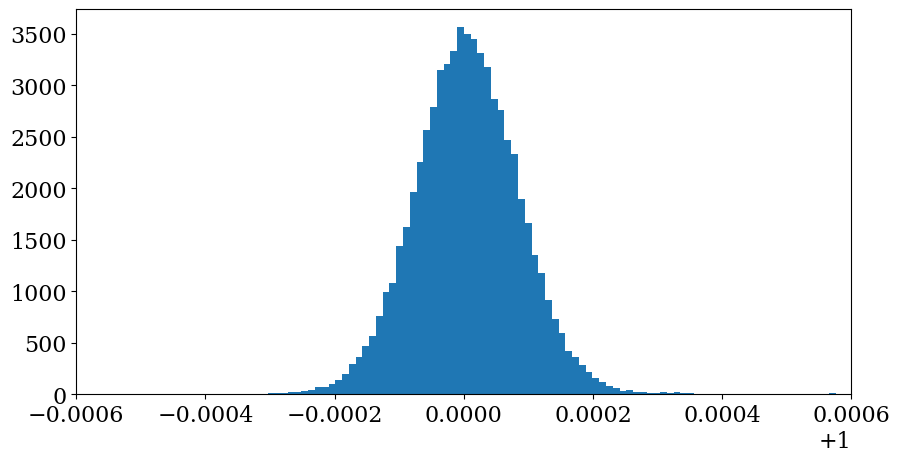

In [83]:
plt.figure(figsize=(10,5))
plt.hist(difference, bins=1000)
plt.xlim(0.9994, 1.0006)

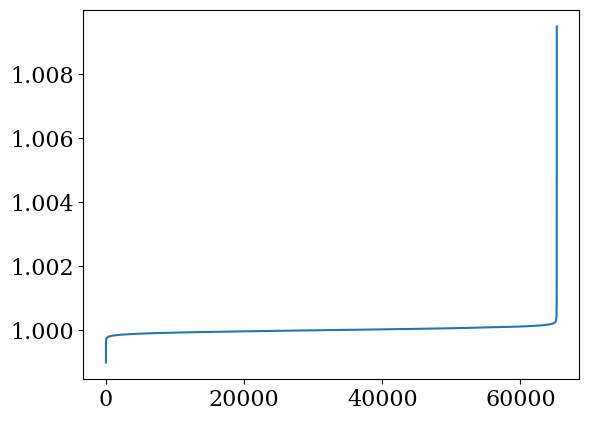

In [84]:
diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)

In [85]:
# find the two points to get std 

f = lambda x: np.interp(x, p, diff_sorted)

one_sigma_pos = f((0.8413)*N)
one_sigma_neg = f((1-0.8413)*N)
print(one_sigma_neg, one_sigma_pos)

std_calculated = (one_sigma_pos - one_sigma_neg)/2
print(std_calculated)


0.9999272760283795 1.0000837597035916
7.82418376060745e-05


(0.999, 1.001)

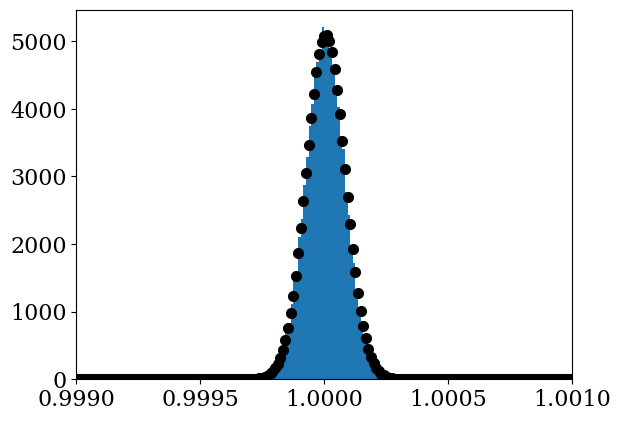

In [86]:
mu, std = norm.fit(difference)  
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.scatter(bins, norm(mu, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mu-(2*std_calculated),color='k')
#plt.axvline(mu+(2*std_calculated),color='k')
plt.xlim(0.999,1.001)

In [87]:
# note how we use the median as the center point to cut around 
mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
print(mean_tweaked)

1.0000046254572899


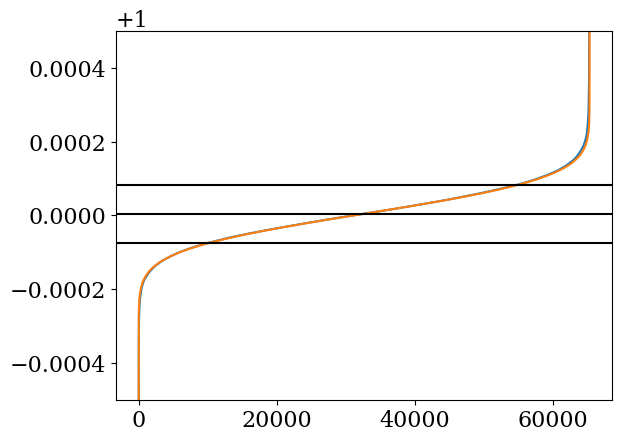

In [88]:
norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)

diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)
plt.plot(norm_cdf*N, diff_sorted)
plt.ylim(0.9995,1.0005)
plt.axhline(mean_tweaked,color='k')
plt.axhline(mean_tweaked-std_calculated,color='k')
plt.axhline(mean_tweaked+std_calculated,color='k')

In [90]:
# find separation of curves 

(0.999, 1.001)

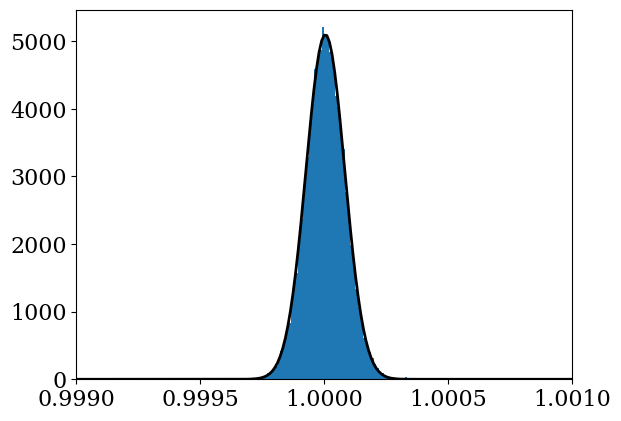

In [91]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
#plt.ylim(1e-6,5000)
plt.xlim(0.999,1.001)
#plt.yscale('log')

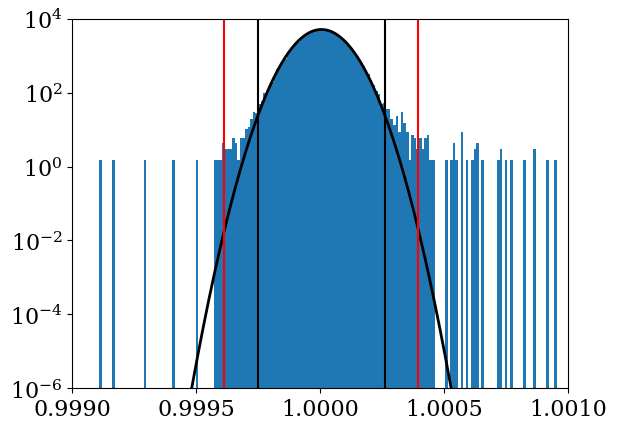

In [92]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
plt.axvline(mean_tweaked-(5*std_calculated),color='red')
plt.axvline(mean_tweaked+(5*std_calculated),color='red')
plt.ylim(1e-6,1e4)
plt.xlim(0.999,1.001)
plt.axvline(1.00026,color='k')
plt.axvline((2*mean_tweaked)-1.00026,color='k')
plt.yscale('log')

## making a couple of outlier flags, first where gaussian turns into slab

(600.0, 700.0)

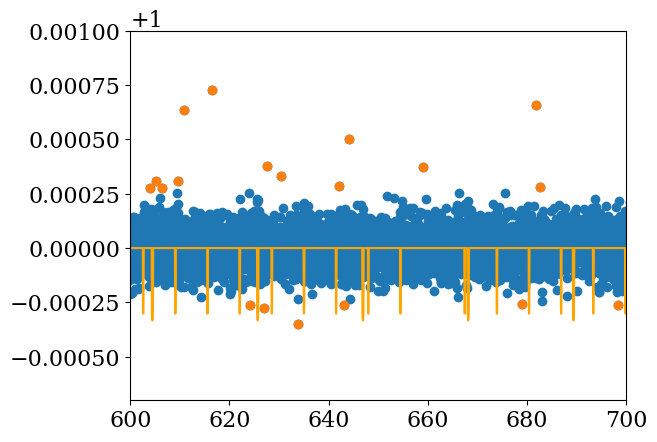

In [93]:
flags_5sigma = ((mean_tweaked-(5*std_calculated)) > difference) | ((mean_tweaked+(5*std_calculated)) < difference)
flags = ((2*mean_tweaked)-1.00026 > difference) | (1.00026 < difference)
plt.scatter(lc.time.value, difference)
plt.scatter(lc.time.value[flags], difference[flags])
plt.plot(lc.time.value, model+1,color='orange')
plt.ylim(0.9993, 1.001)
plt.xlim(600,700)

(0.999, 1.001)

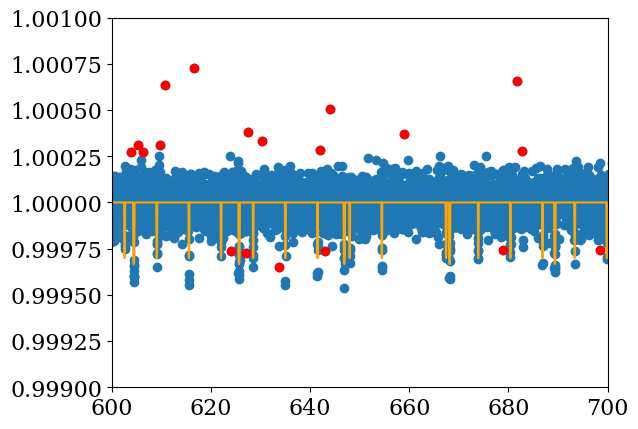

In [94]:
plt.scatter(lc.time.value, lc.flux)
plt.scatter(lc.time.value[flags], lc.flux[flags],color='red')
plt.plot(lc.time.value, model+1,color='orange')
plt.xlim(600,700)
plt.ylim(0.999, 1.001)

In [95]:
sum(flags)

312

In [96]:
len(difference)

65263

In [97]:
377/65263

0.005776626878935998

(0.999, 1.0005)

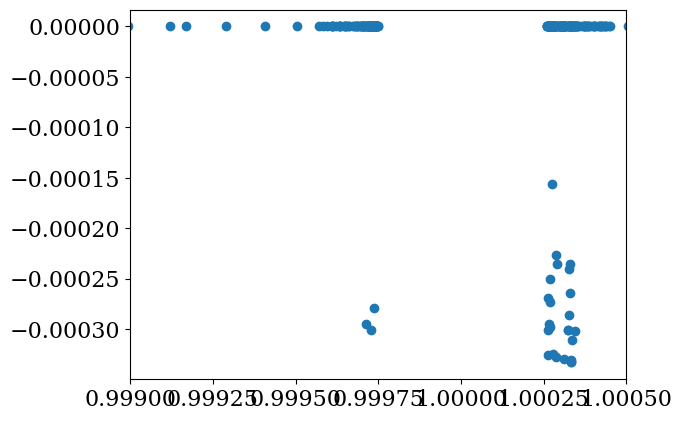

In [98]:
plt.scatter(difference[flags],model[flags])
plt.xlim(0.999,1.0005)

# is this cluster of points a specific phenomenon or incaccurate model 

(0.999, 1.0005)

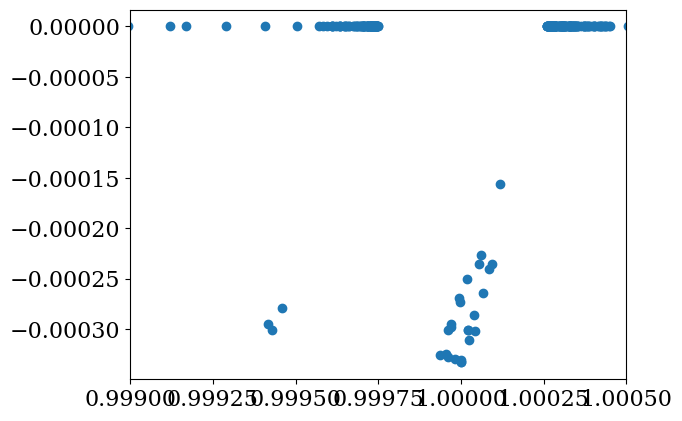

In [99]:
plt.scatter(lc.flux[flags],model[flags])
plt.xlim(0.999,1.0005)


In [100]:
outliers_quality = lc[flags]['quality'].value
print(np.unique(outliers_quality))
print([lk.KeplerQualityFlags.decode(i) for i in np.unique(outliers_quality)])

[     0     16    128    144   2048   2064   2176   2192   8192   8320
   8336  10368 393344]
[[], ['Zero crossing'], ['Cosmic ray in optimal aperture'], ['Zero crossing', 'Cosmic ray in optimal aperture'], ['Impulsive outlier'], ['Zero crossing', 'Impulsive outlier'], ['Cosmic ray in optimal aperture', 'Impulsive outlier'], ['Zero crossing', 'Cosmic ray in optimal aperture', 'Impulsive outlier'], ['Cosmic ray in collateral data'], ['Cosmic ray in optimal aperture', 'Cosmic ray in collateral data'], ['Zero crossing', 'Cosmic ray in optimal aperture', 'Cosmic ray in collateral data'], ['Cosmic ray in optimal aperture', 'Impulsive outlier', 'Cosmic ray in collateral data'], ['Cosmic ray in optimal aperture', 'Rolling band in optimal aperture', 'Rolling band in full mask']]


In [101]:
outliers_0 = [lc[flags]['quality']==0]
outliers_16 = [lc[flags]['quality']==16]
outliers_128 = [lc[flags]['quality']==128]
outliers_144 = [lc[flags]['quality']==144]
outliers_2048 = [lc[flags]['quality']==2048]
outliers_2064 = [lc[flags]['quality']==2064]
outliers_2176 = [lc[flags]['quality']==2176]
outliers_2192 = [lc[flags]['quality']==2192]
outliers_8192 = [lc[flags]['quality']==8192]
outliers_8320 = [lc[flags]['quality']==8320]
outliers_8336 = [lc[flags]['quality']==8336]
outliers_10368 = [lc[flags]['quality']==10368]
outliers_393344 = [lc[flags]['quality']==393344]

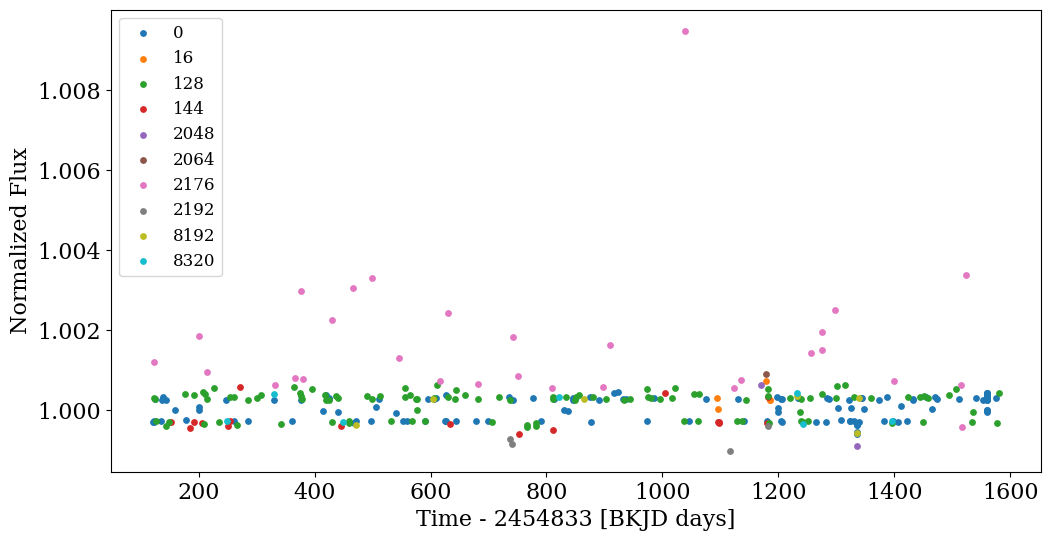

In [102]:
fig, ax = plt.subplots(figsize=(12,6))
lc[flags][outliers_0].scatter(ax=ax,marker='o',s=15,label='0',zorder=1)
lc[flags][outliers_16].scatter(ax=ax,marker='o',s=15,label='16',zorder=1)
lc[flags][outliers_128].scatter(ax=ax,marker='o',s=15,label='128',zorder=3)
lc[flags][outliers_144].scatter(ax=ax,marker='o',s=15,label='144',zorder=2)
lc[flags][outliers_2048].scatter(ax=ax,marker='o',s=15,label='2048',zorder=4)
lc[flags][outliers_2064].scatter(ax=ax,marker='o',s=15,label='2064',zorder=5)
lc[flags][outliers_2176].scatter(ax=ax,marker='o',s=15,label='2176',zorder=6)
lc[flags][outliers_2192].scatter(ax=ax,marker='o',s=15,label='2192',zorder=6)
lc[flags][outliers_8192].scatter(ax=ax,marker='o',s=15,label='8192',zorder=6)
lc[flags][outliers_8320].scatter(ax=ax,marker='o',s=15,label='8320',zorder=6)
#plt.plot(lc.time.value, model+1,color='orange')

#lc[flags][outliers_8336].scatter(ax=ax,marker='o',s=15,label='8336',zorder=6)
#lc[flags][outliers_10368].scatter(ax=ax,marker='o',s=15,label='10368',zorder=6)
#lc[flags][outliers_393344].scatter(ax=ax,marker='o',s=15,label='393344',zorder=6)
plt.legend(fontsize=12)
#plt.xlim(1300,1400)

In [103]:
lk.KeplerQualityFlags.decode(2192)

['Zero crossing', 'Cosmic ray in optimal aperture', 'Impulsive outlier']

### clumping of outliers with no quality flags 

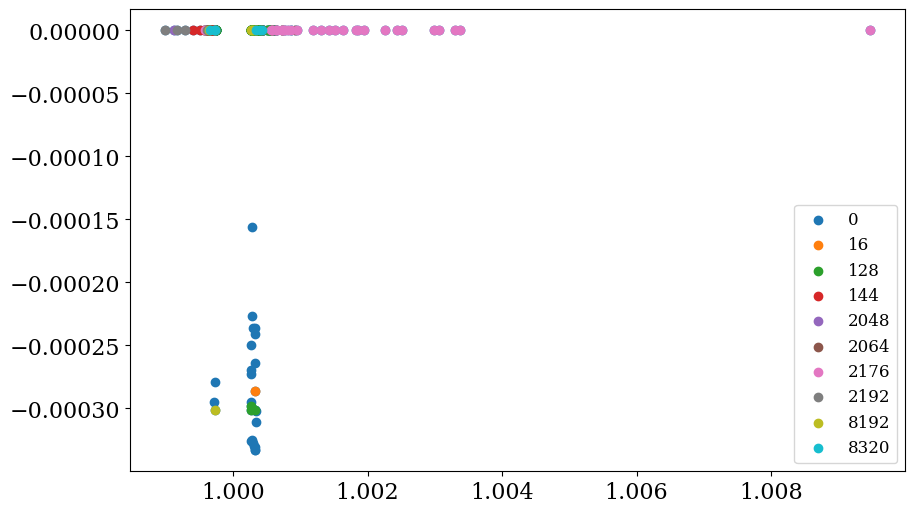

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(difference[flags],model[flags],label='0')
plt.scatter(difference[flags][outliers_16],model[flags][outliers_16],label='16')
plt.scatter(difference[flags][outliers_128],model[flags][outliers_128],label='128')
plt.scatter(difference[flags][outliers_144],model[flags][outliers_144],label='144')
plt.scatter(difference[flags][outliers_2048],model[flags][outliers_2048],label='2048')
plt.scatter(difference[flags][outliers_2064],model[flags][outliers_2064],label='2064')
plt.scatter(difference[flags][outliers_2176],model[flags][outliers_2176],label='2176')
plt.scatter(difference[flags][outliers_2192],model[flags][outliers_2192],label='2192')
plt.scatter(difference[flags][outliers_8192],model[flags][outliers_8192],label='8192')
plt.scatter(difference[flags][outliers_8320],model[flags][outliers_8320],label='8320')
#plt.scatter(difference[flags][outliers_8336],model[flags][outliers_8336],label='8336',color='k')
#plt.scatter(difference[flags][outliers_10368],model[flags][outliers_8336],label='10368',color='k')
#plt.scatter(difference[flags][outliers_393344],model[flags][outliers_8336],label='393344',color='k')

plt.legend(fontsize=12)
#plt.xlim(0.999,1.0005)

## now trying 5 sigma, no clumping 

(0.999, 1.001)

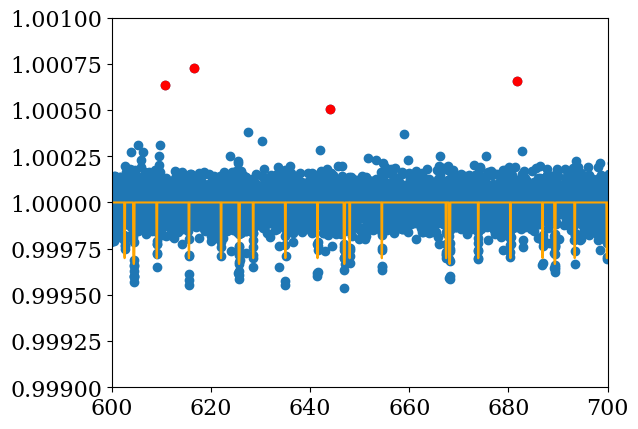

In [108]:
plt.scatter(lc.time.value, lc.flux)
plt.scatter(lc.time.value[flags_5sigma], lc.flux[flags_5sigma],color='red')
plt.plot(lc.time.value, model+1,color='orange')
plt.xlim(600,700)
plt.ylim(0.999, 1.001)

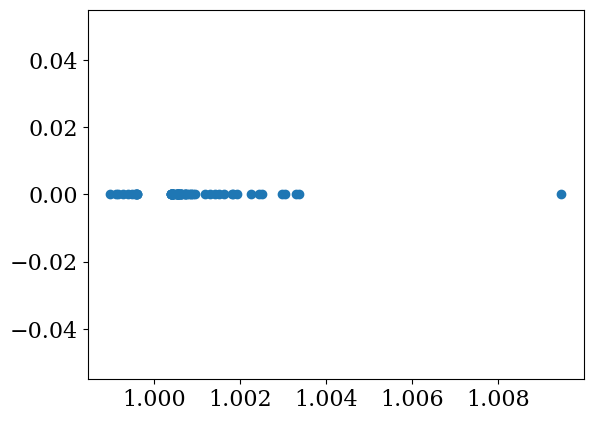

In [109]:
plt.scatter(difference[flags_5sigma],model[flags_5sigma])
#plt.xlim(0.999,1.0005)

In [106]:
lc_clean = lc[~flags_5sigma]

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

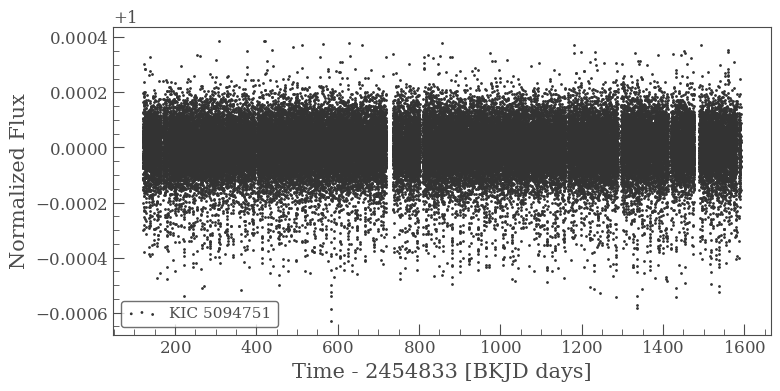

In [107]:
lc_clean.scatter()

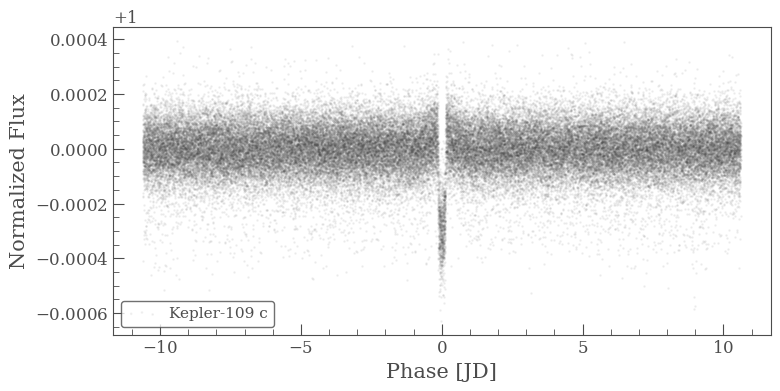

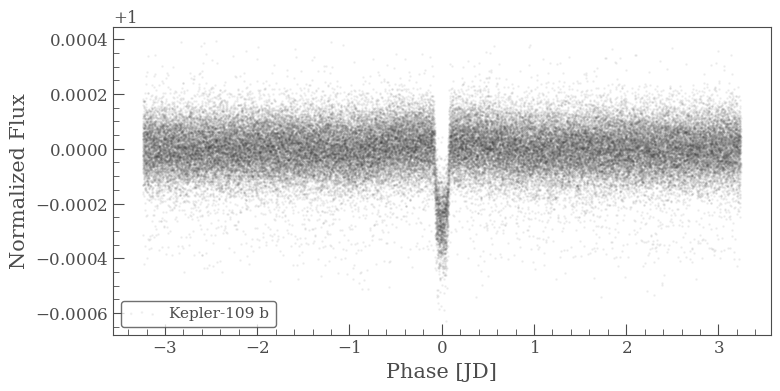

In [76]:
for i in range(len(planet_parameters)):
    ax = lc_clean.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"],
                                 format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"], alpha=0.05)
    plt.show()